## Ganesh Gorti, 5th December 2021

### Deep learning model try (see previous notebook for code on regression models)

This code analyses maximum indoor temperature data from 60 households in New Delhi, India. The data was collected between April 2017 and October 2017. The aim of this analysis is to predict the maximum indoor temperatures daily based on a range of features. These include

Daily maximum outdoor temperature (in degree celsius)
Daily maximum outdoor humidity
Daily maximum outdoor windspeed (in KMPH)
Daily maximum heatindex
Daily maximum rainfall. (in mm)
Daily maximum solar radiation
Area
Floor of the house
Floor on top (dummy coded as yes or no)
Roof Structure (tin sheet, stone slab, concrete, bricks)
Wall material (concrete/bricks)
Number of ceiling fans
Number of evaporative coolers
Flowing ventilation (coded as 0 if no ventilation, 1 if windows are present)
Local Climate Zone classification
Outcome variable -- temp

In [122]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import sklearn

In [123]:
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.collections import PolyCollection

## Loading Data

In [124]:
indoortemp_df = pd.read_csv('https://raw.githubusercontent.com/GaneshGorti/spatialml/main/masterdata.csv') 
indoortemp_df.head()

,logger,date,temp,Temp_Out,Out_Hum,Wind_Speed,Heat_Index,Rain,Solar_Rad,Area,Humidity_sensor,Floor,Floor_on_top,Roof_structure,Wall_material,Fan,Evaporative_cooler,Flowing_ventilation,LCZ
0,10692989,12/04/16,31.4,34.3,29,1.8,32.5,0.0,906,Railway Colony,yes,4,no,concrete,bricks,1,yes,1.0,2
1,10692990,12/04/16,31.5,34.3,29,1.8,32.5,0.0,906,Kasturbha Nagar,yes,1,no,concrete,bricks,1,yes,1.0,5
2,10692993,12/04/16,32.7,34.3,29,1.8,32.5,0.0,906,Sarai Kale Khan,yes,3,yes,floor on top,bricks,1,yes,0.0,3
3,10692995,12/04/16,32.9,34.3,29,1.8,32.5,0.0,906,Lodhi Colony,yes,2,no,concrete,bricks,1,yes,1.0,6
4,10692998,12/04/16,32.4,34.3,29,1.8,32.5,0.0,906,Patparganj slum,yes,0,yes,floor on top,bricks,1,yes,1.0,2


In [125]:
indoortemp_df.isnull().sum().sum()
indoorcleaned_df = indoortemp_df.dropna()

### Exploring the data

In [126]:
#Dropping Area column 
indoorcleaned_df.drop(columns=['Area'], inplace=True)
indoorcleaned_df.shape

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


(8039, 18)

In [127]:
#Data Distribution
indoorcleaned_df.iloc[:,6:].describe().T

,count,mean,std,min,25%,50%,75%,max
Heat_Index,8039.0,41.322515,4.545295,31.2,38.1,41.3,44.70,52.00
Rain,8039.0,1.714142,5.978278,0.0,0.0,0.0,0.25,39.12
Solar_Rad,8039.0,693.856325,184.398678,0.0,614.0,747.0,825.00,966.00
Floor,8039.0,1.779201,1.328815,0.0,1.0,1.0,3.00,4.00
Fan,8039.0,0.867770,0.338762,0.0,1.0,1.0,1.00,1.00
Flowing_ventilation,8039.0,0.583841,0.460763,0.0,0.0,1.0,1.00,1.00
LCZ,8039.0,3.787163,1.625363,2.0,2.0,3.0,5.00,6.00


Target variable distribution

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Target variable Distribution Plot')

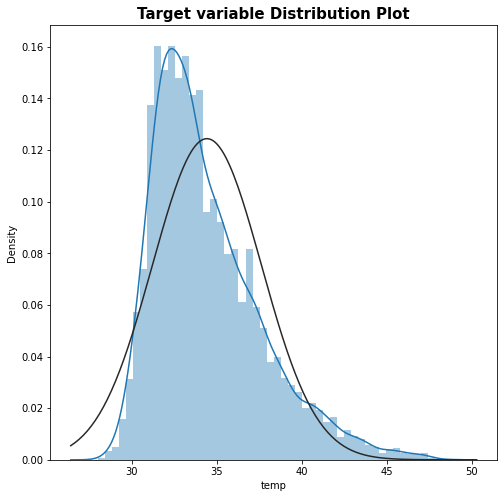

In [128]:
from scipy.stats import norm
plt.figure(figsize=(8,8))
sns.distplot(indoorcleaned_df['temp'], fit=norm)
plt.title("Target variable Distribution Plot",size=15, weight='bold')

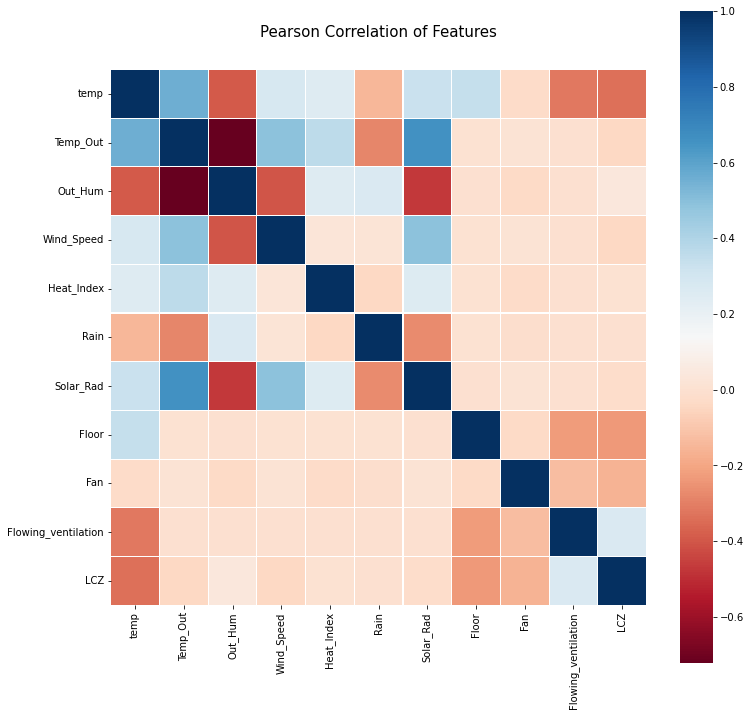

In [129]:
#Drop some unnecessary features that are not required for the correlation plots
features_for_plot = indoorcleaned_df.drop(columns=['logger', 'date'])
#Correlation matrix
colormap = plt.cm.RdBu
plt.figure(figsize=(12,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(features_for_plot.corr(),linewidths=0.1,vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=False)
plt.show()

### Creating features and target variable

In [130]:
indoorcleaned_df = pd.get_dummies(indoorcleaned_df)
features = indoorcleaned_df.drop(columns=['logger', 'temp'])
X = features.values
y = indoorcleaned_df['temp'].values

#Let's shuffle the data to minimize the effect of the orginal order of training/testing data on our results:
np.random.seed(42)
indices = np.arange(len(X))
np.random.shuffle(indices)
X = X[indices]
y = y[indices]
X.shape

(8039, 209)

In [131]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=42)

In [132]:
# Scaling the features using StandardScaler
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)

In [133]:
X_train = X_train_std
X_test = X_test_std

## Feed Forward Neural Network

In [134]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dropout, Flatten, Dense
from keras import Sequential
from tensorflow.nn import relu

tf.random.set_seed(21)

#Creating a sequential model with 1 hidden layer and drop out layer

model = Sequential([
    Dense(10, activation = relu), 
    Dropout(.1), 
    Dense(10, activation = relu),
    Dropout(.1),
    Dense(1)
])

model.compile(optimizer=tf.optimizers.Adam(), 
              loss='mse',
              metrics=['mae', 'mse'])

In [135]:
#Making the output less verbose
class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: print('')
        print('.', end='')

#Creating an early_stop function with a patience of 4. 
early_stop = keras.callbacks.EarlyStopping(monitor='val_mse', patience=4)

#Fitting the model on training data with a validation split of 0.1
ff_model = model.fit(X_train, y_train, epochs=1000, verbose=0, validation_split = 0.1,
                    callbacks=[early_stop, PrintDot()])


..................

In [136]:
#Creating a datafram to store loss, MSE, and MAE for each epoch 
hist = pd.DataFrame(ff_model.history)
hist['epoch'] = ff_model.epoch

#Calculating RMSE 
rmse_final = np.sqrt(float(hist['val_mse'].tail(1)))

print('Final Root Mean Square Error on validation set: {}'.format(round(rmse_final, 3)))

Final Root Mean Square Error on validation set: 2.038


In [137]:
hist

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
0,801.427734,27.325077,801.427734,252.835770,14.221697,252.835770,0
1,116.639488,8.470289,116.639488,35.715862,4.197237,35.715862,1
2,63.942932,6.217823,63.942932,17.157063,2.887008,17.157063,2
3,52.488945,5.676965,52.488945,11.644720,2.493256,11.644720,3
4,47.013714,5.465268,47.013714,8.186923,2.135745,8.186923,4
5,45.471203,5.321202,45.471203,6.300998,1.904143,6.300998,5
6,41.208687,5.063767,41.208687,5.840890,1.887474,5.840890,6
7,42.459126,5.176371,42.459126,5.970162,1.921275,5.970162,7
8,39.845654,5.036564,39.845654,5.106635,1.749861,5.106635,8
9,38.818016,4.951037,38.818016,5.000341,1.717769,5.000341,9


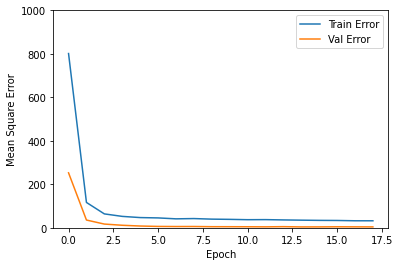

In [138]:
# plot validation and training error against number of epochs
def plot_history():
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error')
    plt.plot(hist['epoch'], hist['mse'], label='Train Error')
    plt.plot(hist['epoch'], hist['val_mse'], label = 'Val Error')
    plt.legend()
    plt.ylim([0,1000])
# 
plot_history()

In [139]:
#Evaluating the model on the test set 
mse, _, _ = model.evaluate(X_test, y_test)
rmse = np.sqrt(mse)
print('Root Mean Square Error on test set: {}'.format(round(rmse, 3)))

26/26 [==============================] - 0s 3ms/step - loss: 4.1493 - mae: 1.5316 - mse: 4.1493
Root Mean Square Error on test set: 2.037


In [140]:
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 10)                2100      
                                                                 
 dropout_2 (Dropout)         (None, 10)                0         
                                                                 
 dense_4 (Dense)             (None, 10)                110       
                                                                 
 dropout_3 (Dropout)         (None, 10)                0         
                                                                 
 dense_5 (Dense)             (None, 1)                 11        
                                                                 
Total params: 2,221
Trainable params: 2,221
Non-trainable params: 0
_________________________________________________________________


In [141]:
!pip install -q -U keras-tuner

###HyperModel

In [142]:
import kerastuner as kt
from kerastuner import HyperModel

In [143]:
#Bullding a class with the hyper model; using only relu for activation 
class RegressionHyperModel(HyperModel):

    def __init__(self, input_shape):
        self.input_shape = input_shape    
    
    def build(self, hp): 
        model = Sequential()
        model.add(
            Dense( # add a dense layer
                units=hp.Int('units', 6, 60, 5, default=6),
                activation=hp.Choice(
                      'dense_activation',
                    values=['relu'],
                    default='relu'),
                input_shape=input_shape
            )
        )
        model.add( 
            Dropout(
                rate = hp.Float(
                    'dropout',
                    min_value=0.0,
                    max_value=0.5,
                    default=0.005,
                    step=0.05)
            )
        )
        model.add(
            Dense(
                units=hp.Int('units', 6, 120, 5, default=12),
                activation=hp.Choice(
                    'dense_activation',
                    values=['relu'],
                    default='relu')
            )
        )  
        model.add(
            Dropout(
                rate = hp.Float(
                    'dropout',
                    min_value=0.0,
                    max_value=0.5,
                    default=0.005,
                    step=0.05)
            )
        ) 
        model.add(
            Dense(1)
            )
            
        
        #Compile
        model.compile(
            optimizer=keras.optimizers.Adam(
                hp.Choice('learning_rate', 
                          values=[1e-2, 1e-3])),
                      loss='mse',
                      metrics=['mse'])
        return model

In [144]:
#Number of features
input_shape = (X_train.shape[1],) 
#class RegressionHyperModel 
hypermodel = RegressionHyperModel(input_shape) 

In [145]:
#Defining to clear training output after each run of hyperparam tuning
import IPython
class ClearTrainingOutput(tf.keras.callbacks.Callback):
  def on_train_end(*args, **kwargs):
    IPython.display.clear_output(wait = True)

###HyperBand search

In [146]:
#Hyperband tuner with factor 4 and iterations 1
from kerastuner import Hyperband
# Hyperband optimization 
tuner_hb = Hyperband(
            hypermodel,
            objective='val_mse',  
            factor=4, 
            hyperband_iterations=1,
            seed=42,
            overwrite=True   
        )

In [147]:
#Tuning the hyperband
tuner_hb.search(X_train, y_train, epochs=20, validation_split=0.1, verbose=0, 
                callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=4), ClearTrainingOutput()])

INFO:tensorflow:Oracle triggered exit


###Inspecting and refitting the best model

In [148]:
best_model_hb = tuner_hb.get_best_models(num_models=1)[0]
best_model_hb.evaluate(X_test, y_test)

26/26 [==============================] - 0s 3ms/step - loss: 2.2636 - mse: 2.2636


[2.2635767459869385, 2.2635767459869385]

In [149]:
tuned_model = tuner_hb.get_best_models(1)[0]
tuned_model_params = tuned_model.get_config()

In [150]:
for i in range(1, len(tuned_model_params['layers'])-1):
  print('layer number: {}'.format(i))
  if i%2 == 0:
    print('layer name: {}'.format(tuned_model_params['layers'][i]['config']['name']), ', dropout rate: {}'.format(tuned_model_params['layers'][i]['config']['rate']))
  else:
    print('layer name: {}'.format(tuned_model_params['layers'][i]['config']['name']), ', activation: {}'.format(tuned_model_params['layers'][i]['config']['activation']), ', number of nodes: {}'.format(tuned_model_params['layers'][i]['config']['units']))
  print('---------------------------------------')

layer number: 1
layer name: dense , activation: relu , number of nodes: 41
---------------------------------------
layer number: 2
layer name: dropout , dropout rate: 0.25
---------------------------------------
layer number: 3
layer name: dense_1 , activation: relu , number of nodes: 41
---------------------------------------
layer number: 4
layer name: dropout_1 , dropout rate: 0.25
---------------------------------------


In [151]:
best_model_hb = tuner_hb.get_best_models(num_models=1)[0]
best_model_hb.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 41)                8610      
                                                                 
 dropout (Dropout)           (None, 41)                0         
                                                                 
 dense_1 (Dense)             (None, 41)                1722      
                                                                 
 dropout_1 (Dropout)         (None, 41)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 42        
                                                                 
Total params: 10,374
Trainable params: 10,374
Non-trainable params: 0
_________________________________________________________________


In [152]:
indoortemp_tuned_model_hb = best_model_hb.fit(X_train, y_train, epochs=1000, verbose=0, validation_split = 0.1,
                    callbacks=[early_stop, PrintDot()])


...........

In [153]:
hist_tuned_hb = pd.DataFrame(indoortemp_tuned_model_hb.history)
hist_tuned_hb['epoch'] = indoortemp_tuned_model_hb.epoch

# show RMSE measure 
rmse_final = np.sqrt(float(hist_tuned_hb['val_mse'].tail(1)))

print('Root Mean Square Error on validation set after tuning: {}'.format(round(rmse_final, 3)))

Root Mean Square Error on validation set after tuning: 1.66


In [154]:
hist_tuned_hb

,loss,mse,val_loss,val_mse,epoch
0,7.602757,7.602757,2.512745,2.512745,0
1,7.232864,7.232864,2.926336,2.926336,1
2,6.473098,6.473098,2.403380,2.403380,2
3,6.475968,6.475968,2.539778,2.539778,3
4,6.296517,6.296517,2.743249,2.743249,4
5,6.071621,6.071621,2.366963,2.366963,5
6,5.775817,5.775817,2.343122,2.343122,6
7,5.415469,5.415469,2.822937,2.822937,7
8,5.078903,5.078903,2.370230,2.370230,8
9,4.837452,4.837452,2.373446,2.373446,9


In [155]:
loss_tuned, mse_tuned = best_model_hb.evaluate(X_test, y_test)

print('Root Mean Square Error on test set after tuning: {}'.format(round(np.sqrt(mse_tuned), 3)))

best_hps = tuner_hb.get_best_hyperparameters(num_trials = 1)[0]

print("and the optimal learning rate for the optimizer is {}".format(best_hps.get('learning_rate')))


26/26 [==============================] - 0s 3ms/step - loss: 2.5883 - mse: 2.5883
Root Mean Square Error on test set after tuning: 1.609
and the optimal learning rate for the optimizer is 0.01
